In [1]:
import ROOT as r
from ROOT import gSystem
from ROOT import gStyle
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mp
import itertools
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Activation
import sys
from array import array
from VBSAnalysis.EventIterator import EventIterator
import argparse
from sklearn import metrics
from keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
from sklearn.model_selection import KFold
from scipy import interp
from keras.utils import plot_model, print_summary
from keras.models import load_model
from operator import attrgetter, itemgetter
from itertools import combinations
import myplotter as plotter
import ROOT as r
import sys
from operator import attrgetter, itemgetter
from array import array
from VBSAnalysis.EventIterator import EventIterator
from VBSAnalysis.Utils import JetSelectors as jsel
from VBSAnalysis import JetTagging 
import argparse
import myplotter as plotter
from collections import namedtuple
from ROOT import gSystem
from ROOT import gStyle
plotter.setStyle()
from keras.callbacks import History 
history = History()
from scipy.stats import pearsonr

Welcome to JupyROOT 6.14/00


/home/giacomo/root/lib/ROOT.py:461: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return _orig_ihook( name, *args, **kwds )
Using TensorFlow backend.
DEBUG:matplotlib.backends] backend module://ipykernel.pylab.backend_inline version unknown


# FUNCTIONS

In [2]:
def to_xy(df, target):
    y = df[:,target]
    x = np.delete(df, target, 1)
    return x,y

def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    #soglia per contrasto colore
    thresh = cm.max() / 1.5 
    #plotto per ogni cella della matrice il valore corrispondente
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black", fontsize=25)
    #plotto il resto
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, fontsize = 20)
    plt.yticks(tick_marks, names, fontsize = 20)
    plt.tight_layout()
    plt.ylabel('True label', fontsize = 20)
    plt.xlabel('Predicted label',fontsize = 20)
    plt.tight_layout()
    
def plot_roc_curve_KFold(tprs, mean_fpr, aucs):
    #plotto la bisettrice, potere di predizione nullo
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='0 pred power', alpha=.8)
    #valore medio del true positive rate
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    #valore medio auc
    mean_auc = auc(mean_fpr, mean_tpr)
    #std deviation auc
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)
    #deviazione standard sui true positive rate (ordinate) prendo il valore medio e aggiungo o 
    #sottraggo la dev standard per riempire l'area di incertezza dell roc curve media sui kfolds
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.1,
                 label=r'$\pm$ 1 std. dev.')
    #plotto labels, titolo, dimensiono assi e legenda
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")

def plot_roc_curve(y_test, pred):
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b',
    label='0 pred power', alpha=.8)
    fp , tp, th = roc_curve(y_test, pred)
    roc = roc_auc_score(y_test, pred)
    plt.plot(fp, tp, 'r', label='ROC binary categorizzation (AUC = %0.3f)' %(roc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")
    
def model_score(y_test, pred, th):
    if th ==0.5:
        pred = np.rint(pred)
    else:
        i=0
        while i<len(pred):
            if pred[i]>th:
                pred[i]=1;
            else:
                pred[i]=0;
            i=i+1
    return metrics.accuracy_score(y_test,pred)

def mkdir_p(mypath):
    #crea una directory

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: 
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise


# LOADING  MODEL

In [3]:
model = load_model("modelli_giacomo/modellobinariojp")
data = np.load('dataset.npy')
x,y = to_xy(data, 10)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=42)
data.shape

(467665, 11)

2018-09-11 17:30:30.869784: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


In [4]:
print_summary(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 80)                8080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                4050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total para

In [5]:
weight=model.weights

In [6]:
#model.compile(loss ='binary_crossentropy', optimizer='adam')
#model.fit(x,y,validation_data=(x_test,y_test), verbose=1, epochs=10, batch_size=32, class_weight=weight)

# ROC CURVE

467665/467665 [==============================] - 1s 1us/step
0.34613785761531113


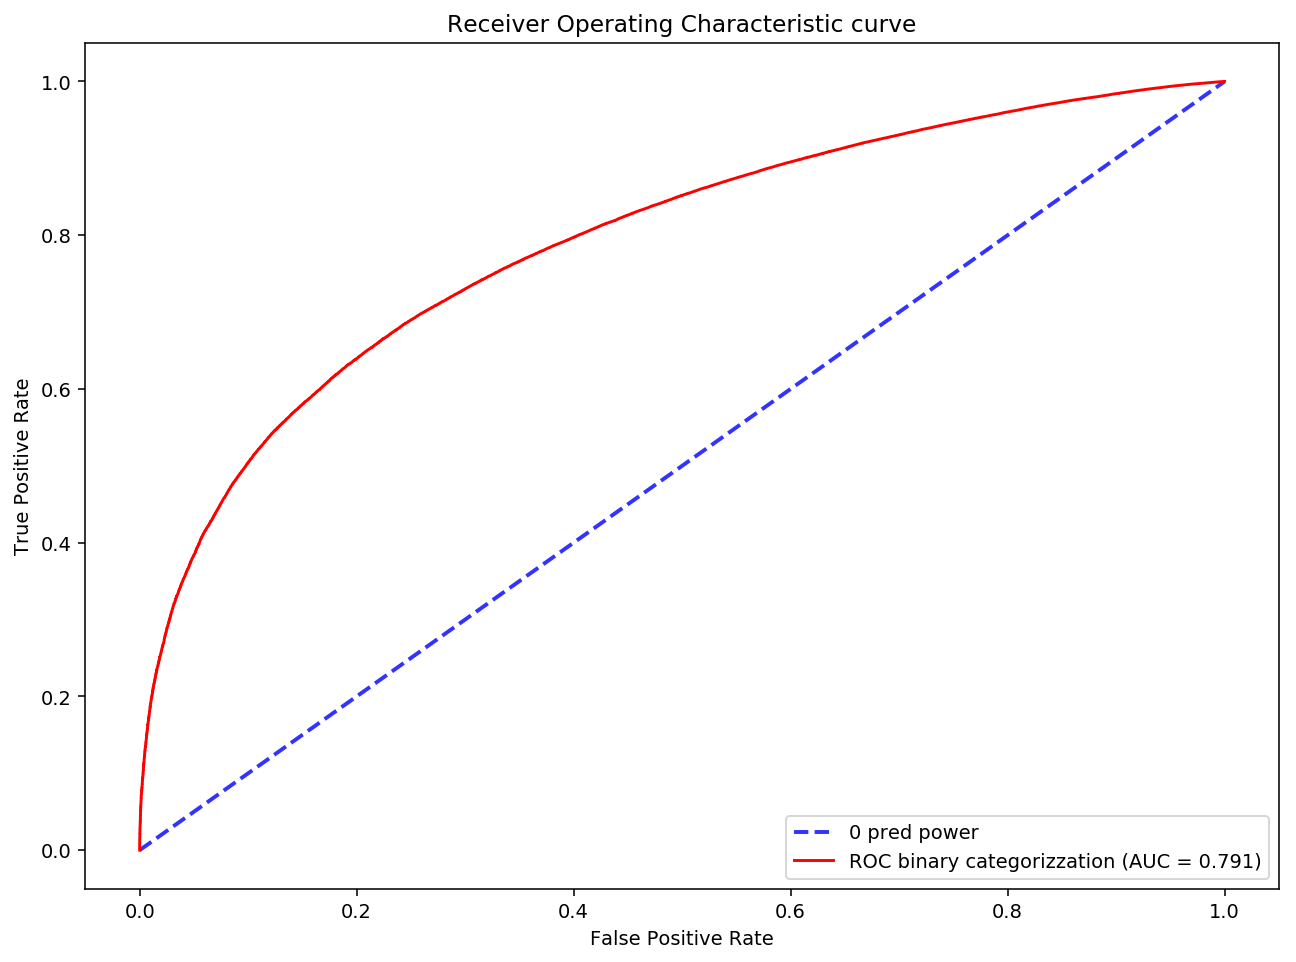

<Figure size 2800x2800 with 0 Axes>

In [18]:
pred = model.predict(x)
auc = roc_auc_score(y, pred)
mp.rc('figure', figsize=(11,8), dpi=140)
fig0 = plt.gcf()
plot_roc_curve(y, pred)
plt.figure(figsize=(20,20))
plt.draw()
fig0.savefig("/home/giacomo/tesi1/VBSAnalysis/images/load_model/Roc_and_graphs/roc_PJAssoc_bin.png")
plt.clf()
loss_and_metrics = model.evaluate(x,y, batch_size = 1024)
print(loss_and_metrics)

# CORRELATION MATRIX

In [33]:
corr = np.corrcoef(y)

In [24]:
print(corr)

(1.0, 0.0)


# ZERO, UNO, SUM SCORE GRAPHS

In [84]:
ths = []
score_zeros = []
score_unos = []
pred = model.predict(x)
th = 0.3
k = 0
while th < 0.9:
    zeroindex = []
    unoindex = []
    i=0
    for j in pred:
        if j<th:
            zeroindex.append(i)
        else:
            unoindex.append(i)
        i=i+1

    newpredzero = []
    newpreduno = []
    zero_y_test = []
    uno_y_test = []
    for num in zeroindex:
        newpredzero.append(pred[num])
        zero_y_test.append(y[num])

    for num in unoindex:
        newpreduno.append(pred[num])
        uno_y_test.append(y[num])
    
    score_zero=metrics.accuracy_score(zero_y_test,[0]*len(newpredzero))
    score_uno=metrics.accuracy_score(uno_y_test,[1]*len(newpreduno))
    ths.append(th)
    score_zeros.append(score_zero)
    score_unos.append(score_uno)
    th = th + 0.001
    k=k+1



DEBUG:matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.0 to DejaVu Sans ('/home/giacomo/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0 to DejaVu Sans ('/home/giacomo/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


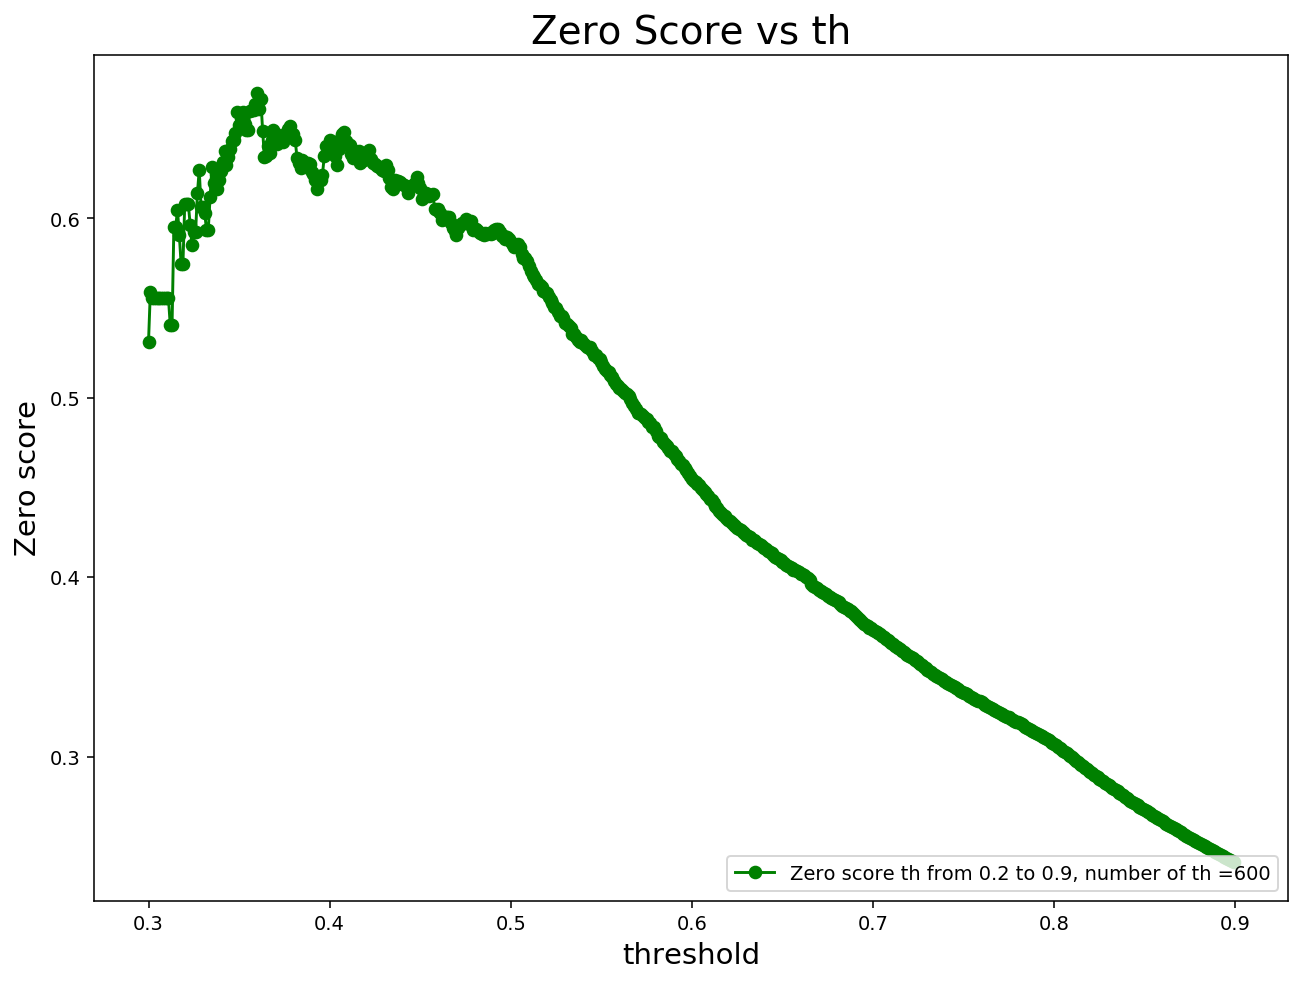

In [85]:
plt.clf()
plt.gcf()
plt.plot(ths, score_zeros, 'g-o', label="Zero score th from 0.2 to 0.9, number of th ={}".format(k))
plt.title('Zero Score vs th', fontsize=20)
plt.xlabel('threshold', fontsize=15)
plt.ylabel('Zero score', fontsize=15)
plt.legend(loc="lower right")
plt.draw()
plt.savefig("/home/giacomo/tesi1/VBSAnalysis/images/load_model/Roc_and_graphs/zero_score_n_th_%0.1f.png" % (k))
plt.show()

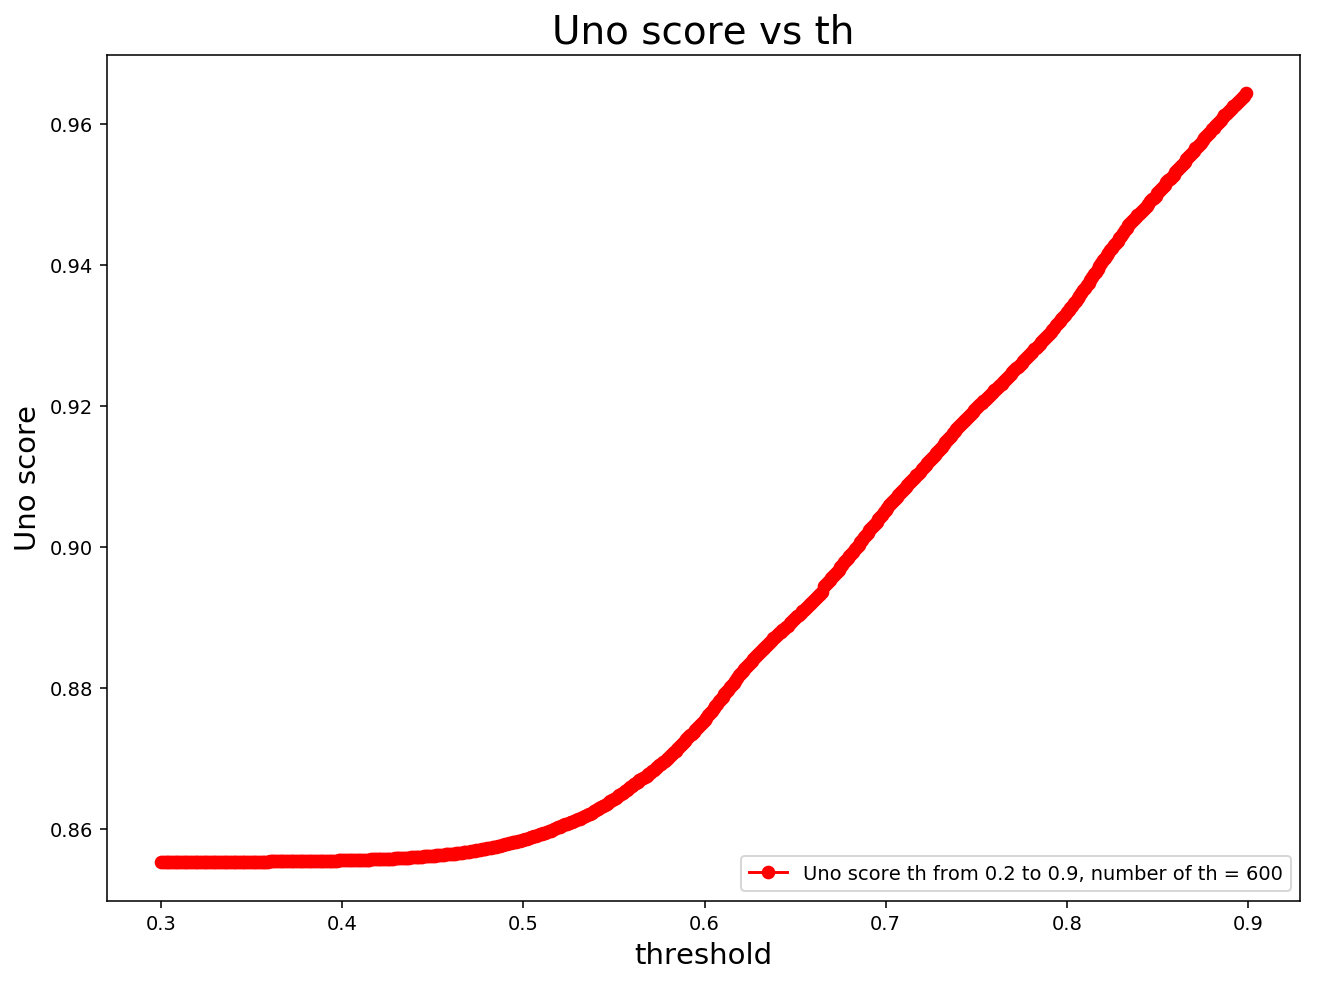

In [86]:
plt.clf()
plt.gcf()
plt.plot(ths, score_unos, 'r-o', label = "Uno score th from 0.2 to 0.9, number of th = {}".format(k))
plt.title('Uno score vs th', fontsize=20)
plt.xlabel('threshold', fontsize=15)
plt.ylabel('Uno score', fontsize=15)
plt.legend(loc="lower right")
plt.draw()
plt.savefig("/home/giacomo/tesi1/VBSAnalysis/images/load_model/Roc_and_graphs/uno_score_n_th_%.1f.png" % (k))
plt.show()

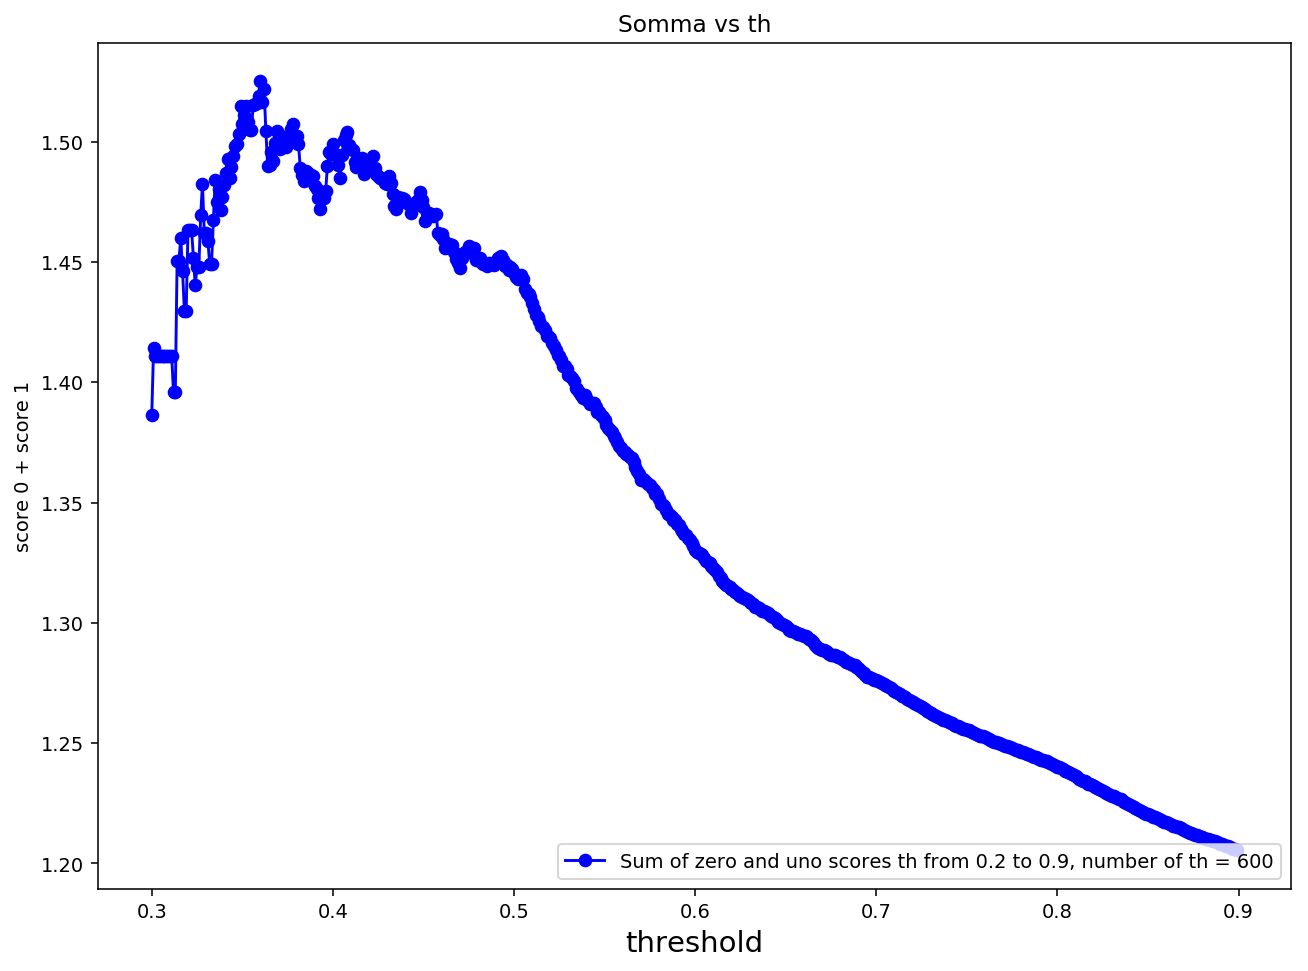

In [87]:
i=0
somma = []
while i < len(score_unos):
    somma.append(score_unos[i]+score_zeros[i])
    i=i+1
plt.clf()
plt.gcf()
plt.plot(ths, somma, 'b-o', label ="Sum of zero and uno scores th from 0.2 to 0.9, number of th = {}".format(k))
plt.title('Somma vs th')
plt.xlabel('threshold', fontsize=15)
plt.ylabel('score 0 + score 1', fontsize=10)
plt.legend(loc="lower right")
plt.draw()
plt.savefig("/home/giacomo/tesi1/VBSAnalysis/images/load_model/Roc_and_graphs/somma_score_n_th_%.1f.png" % (k))
plt.show()

# CONFUSION MATRIX FOR VARIOUS THRESHOLDS

In [ ]:
th = 0.2
while th < 0.9:
    score = model_score(y, pred, th)
    mp.rc('figure', figsize=(10,8), dpi=140)
    pred = model.predict(x)
    if th==0.5:
        pred = np.rint(pred)
    else:
        i=0
        while i<len(pred):
            if pred[i]>th:
                pred[i]=1;
            else:
                pred[i]=0;
            i=i+1
    output_dir = "/home/giacomo/tesi1/VBSAnalysis/images/load_model/matrices/th_%.1f" % (th)
    mkdir_p(output_dir)
    cm = confusion_matrix(y, pred)
    plt.clf()
    plot_confusion_matrix(cm,[0,1], title='Not normalized confusion matrix th = %.1f' % (th))
    plt.draw()
    plt.savefig(output_dir + "/NNCM_th_%.1f.png" % (th))
    plt.clf()
    np.set_printoptions(precision=2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized,[0,1], title='Normalized confusion matrix th = %.1f' % (th))
    plt.draw()
    plt.savefig(output_dir + "/NCM_th_%.1f.png" % (th))
    plt.clf()
    th = th + .1

DEBUG:matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=25.0 to DejaVu Sans ('/home/giacomo/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


# HISTO OF SCORES BASED ON THRESHOLD ON PREDICTED

In [54]:
pred = model.predict(x)
th = 0.2
while th < 0.9:
    gStyle.SetOptStat(11)
    gStyle.SetStatY(0.95)
    hzero = r.TH1F("histo zero score th = %.1f" % (th), "histo zero score th = %.1f" % (th), 10, 0, 1)
    huno = r.TH1F("histo uno score th = %.1f" % (th), "histo uno score th = %.1f" % (th), 10, 0, 1)
    huno.SetLineColor(r.kRed)
    hzero.SetLineColor(r.kBlue)
    huno.SetFillStyle(3007)
    hzero.SetFillStyle(3007)
    huno.SetFillColor(r.kRed)
    hzero.SetFillColor(r.kBlue)
    hzero.GetXaxis().SetTitle("score")
    hzero.GetYaxis().SetTitle("entries")
    huno.GetXaxis().SetTitle("score")
    huno.GetYaxis().SetTitle("entries")
    for j in pred:
        if j<th:
            hzero.Fill(j)
        else:
            huno.Fill(j)
    output_dir = "/home/giacomo/tesi1/VBSAnalysis/images/load_model/histoscore/th_%.1f" % (th)
    mkdir_p(output_dir)
    c = r.TCanvas("c", "c", 50, 50, 1000, 800)
    hzero.Draw("hist")
    c1 = r.TCanvas("c1", "c1", 50, 50, 1000, 800)
    huno.Draw("hist")
    gSystem.ProcessEvents()
    img = r.TImage.Create()
    img.FromPad(c)
    img.WriteImage(output_dir + "/zero.png")
    gSystem.ProcessEvents()
    img = r.TImage.Create()
    img.FromPad(c1)
    img.WriteImage(output_dir + "/uno.png")
    c.Delete()
    c1.Delete()
    print("Memory Leaks up warnings?")
    hzero.Reset("ICESM")
    huno.Reset("ICESM")
    th = th + 0.1



Memory Leaks up warnings?


Memory Leaks up warnings?


Memory Leaks up warnings?


Memory Leaks up warnings?


Memory Leaks up warnings?


Memory Leaks up warnings?


Memory Leaks up warnings?


Memory Leaks up warnings?


# HISTO OF SCORES BASED ON TRUE Y VALUE

In [48]:
good = data[data[:,10]==1]
bad = data[data[:,10]==0]
xg,yg = to_xy(good, 10)
xg_train, xg_test, yg_train, yg_test = train_test_split(xg,yg,test_size=0.25,random_state=42)
xb,yb = to_xy(bad, 10)
xb_train, xb_test, yb_train, yb_test = train_test_split(xb,yb,test_size=0.25,random_state=42)
predg = model.predict(xg_test)
predb = model.predict(xb_test)
gStyle.SetOptStat(11)
gStyle.SetStatY(0.95)
hzero = r.TH1F("histo zero score","histo zero score", 10, 0, 1)
huno = r.TH1F("histo uno score", "histo uno score", 10, 0, 1)
huno.SetLineColor(r.kRed)
hzero.SetLineColor(r.kBlue)
huno.SetFillStyle(3007)
hzero.SetFillStyle(3007)
huno.SetFillColor(r.kRed)
hzero.SetFillColor(r.kBlue)
hzero.GetXaxis().SetTitle("score")
hzero.GetYaxis().SetTitle("entries")
huno.GetXaxis().SetTitle("score")
huno.GetYaxis().SetTitle("entries")
print(good.shape)
print(bad.shape)

[[  64.04307833  -42.88133708  -10.32495391 ...    1.67112269
    28.9361545     7.00584582]
 [ -15.28294448   26.59379067 -363.20021124 ...    3.16651535
    11.22464708    4.46807691]
 [ -13.1714982   -60.83073254 -487.12784796 ...    2.75472615
    17.20862508    6.31130548]
 ...
 [  38.97675108   15.73434989  -38.23756969 ...    3.05163126
    15.57956994    4.08621176]
 [ -28.00622489 -197.7886715  1473.37209829 ...    2.95154154
    20.40605484    8.58667382]
 [   1.88935894   35.76241629   89.95496264 ...    2.51354754
    12.07899522    5.07835258]]


(400000, 11)
(67665, 11)


In [71]:
for j in predg:
    huno.Fill(j)
for k in predb:
    hzero.Fill(k)

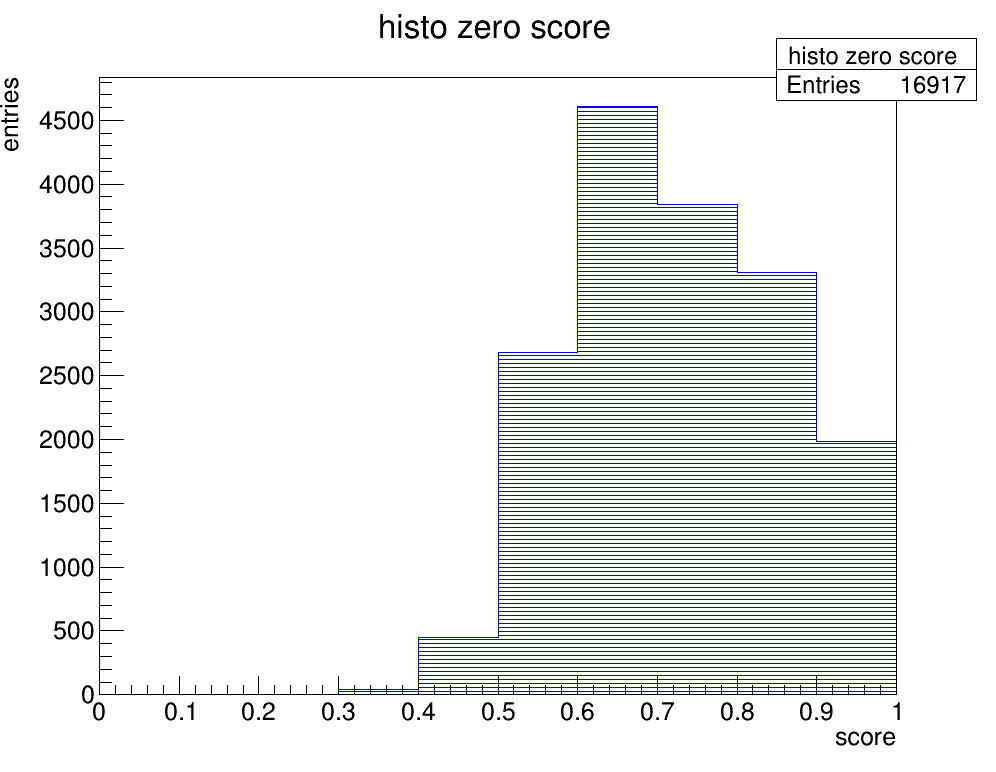

In [72]:
output_dir = "/home/giacomo/tesi1/VBSAnalysis/images/load_model/histoscore"
mkdir_p(output_dir)
czero = r.TCanvas("czero", "czero", 50, 50, 1000, 800)
hzero.Draw("hist")
czero.Draw()
gSystem.ProcessEvents()
img = r.TImage.Create()
img.FromPad(czero)
img.WriteImage(output_dir + "/zerototal.png")

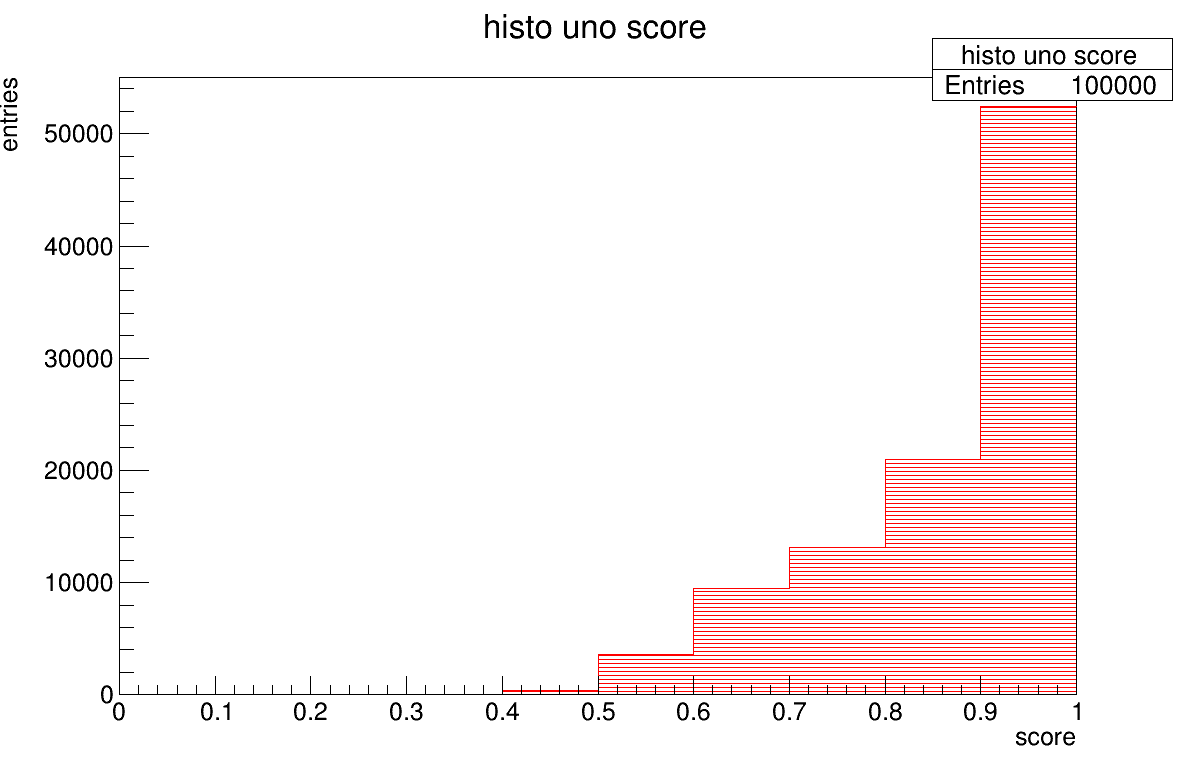

In [73]:
c2 = r.TCanvas("c2", "c2", 50, 50, 1200, 800)
huno.Draw("hist")
c2.Draw()
gSystem.ProcessEvents()
img = r.TImage.Create()
img.FromPad(c2)
img.WriteImage(output_dir + "/unototal.png")

# APPLICAZIONE AI SINGOLI EVENTI

In [8]:
f = r.TFile("data/ewk_giacomo.root")

In [9]:
#qui manca un taglio su maxeta molto probabilmente direi eta max = 4.7
cuts = [
    ("pt_min_jets",30),
    ("min_njets",4),
    #("eta_max_jets", 2),
    ("eq_flag", 0),
    #("n_events", 1)
]

In [15]:
#questo canchero è stra lento va migliorato troppo...
#impiega circa 20/30 minuti

nevento = 0
ones = 0
#zeros = 0
good_event_count = 0
bad_event_count = 0
bad_event = []
b = []
final = []
for evento in EventIterator(f,criteria = cuts, pairing = True) :
    pts = [j.Pt() for j in evento.jets]
    etas = [abs(j.Eta()) for j in evento.jets]
    ms = [j.M() for j in evento.jets]
    maxpt = max(pts)
    minpt = min(pts)
    maxeta = max(etas)
    maxm = max(ms)
    minm = min(ms)
    evento_jets_score = []
    for j in evento.jets:
        if evento.paired_parton(j) == None:
                label = 0
        else:
                label = 1
        datas = np.array([[j.Px(),j.Py(),j.Pz(),j.Pt(),j.E(), 
                                maxpt, minpt, maxeta, maxm, minm]])
        pred = model.predict(datas)[0]
        evento_jets_score.append(([pred, j, label, nevento]))
    evento_jets_score= sorted(evento_jets_score, key= itemgetter(0), reverse=True)
    evento_jets_score = [j[2] for j in evento_jets_score[:4]]
    
    """if evento_jets_score == [1, 1, 1, 1]:
        good_event_count = good_event_count +1
    else:
        zer = 0
        bad_event_count = bad_event_count +1
        for m in evento_jets_score:
            if m == 0:
                zer = zer + 1
        b.append([zer,nevento])"""
                
    zeros = 0 
    for m in evento_jets_score:
        if m == 1:
            ones = ones + 1
        else:
            zeros = zeros + 1
    bad_event.append([zeros, nevento])
    nevento = nevento+1

#print(len(b))
print(ones)
print(zeros)
print(nevento)
#print(bad_event)


"""print(good_event_count)
print(bad_event_count)
print(nevento)
print(b[1:10])"""

4985872
1
1356434


'print(good_event_count)\nprint(bad_event_count)\nprint(nevento)\nprint(b[1:10])'

In [30]:
#print(good_event_count/nevento)
#print(bad_event_count/nevento)
uno_zero=0
due_zero=0
tre_zero=0
histo = r.TH1F("zero label jets in 4 highest score", "zero label jets in 4 highest score", 5, 0, 4)
histo.SetLineColor(r.kRed)
histo.SetFillColor(r.kRed)
histo.SetFillStyle(3005)
quattro_zero=0
for j in bad_event:
    if j[0]==1:
        histo.Fill(1)
        uno_zero = uno_zero+1
    else: 
        if j[0]==2:
            histo.Fill(2)
            due_zero = due_zero+1
        else:
            if j[0] == 3:
                histo.Fill(3)
                tre_zero = tre_zero +1
            else: 
                if j[0] == 4:
                    histo.Fill(4)
                    quattro_zero = quattro_zero+1
                else:
                    if j[0] == 0:
                        histo.Fill(0)
                    
"""print("numero eventi con 1 jet 0 e rateo sul totale bad events")
print(uno_zero, uno_zero/bad_event_count)
print("numero eventi con 2 jet 0 e rateo sul totale bad events")
print(due_zero, due_zero/bad_event_count)
print("numero eventi con 3 jet 0 e rateo sul totale bad events")
print(tre_zero, tre_zero/bad_event_count)
print("numero eventi con 4 jet 0 e rateo sul totale bad events")
print(quattro_zero, quattro_zero/bad_event_count)"""
    
        

'print("numero eventi con 1 jet 0 e rateo sul totale bad events")\nprint(uno_zero, uno_zero/bad_event_count)\nprint("numero eventi con 2 jet 0 e rateo sul totale bad events")\nprint(due_zero, due_zero/bad_event_count)\nprint("numero eventi con 3 jet 0 e rateo sul totale bad events")\nprint(tre_zero, tre_zero/bad_event_count)\nprint("numero eventi con 4 jet 0 e rateo sul totale bad events")\nprint(quattro_zero, quattro_zero/bad_event_count)'

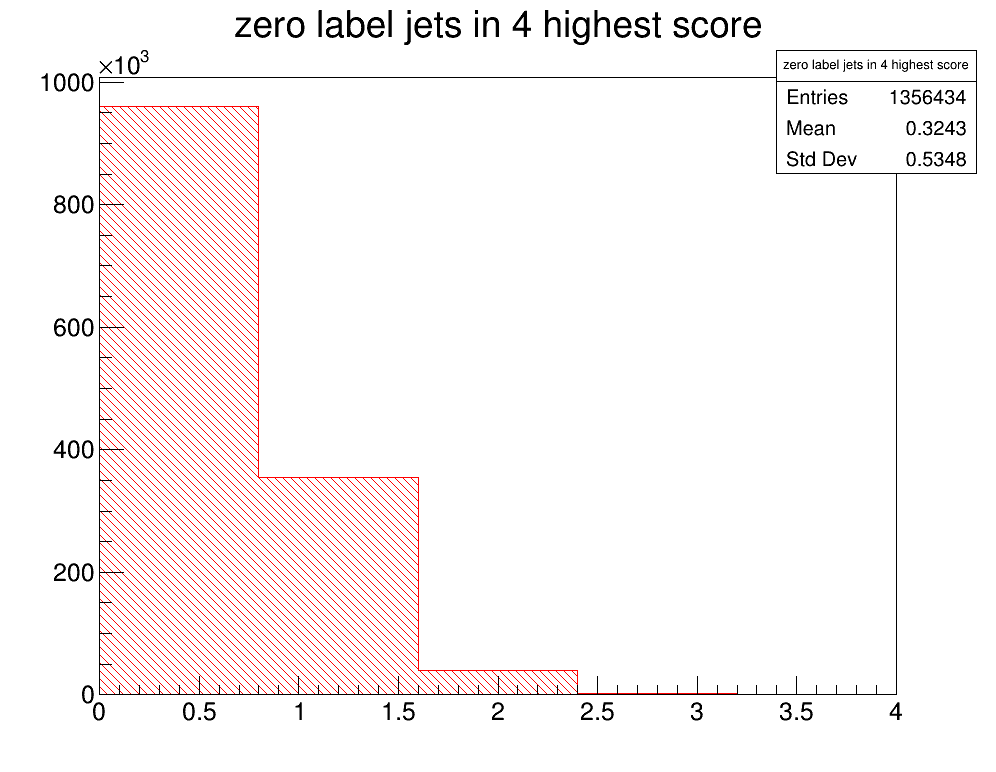

In [31]:
c1 = r.TCanvas("c1", "c1", 50, 50, 1000, 800)
histo.Draw("hist")
c1.Draw()

In [19]:
print(len(bad_event))

1356434


In [13]:
print(zeros/(ones+zeros))
print(ones/(ones+zeros))

0.08106992304822792
0.9189300769517721


# stessa cosa ma prendendo i primi 5 getti

In [34]:
#questo canchero è stra lento va migliorato troppo...
#impiega circa 20/30 minuti

nevento = 0
everyone = 0
noteveryone = 0
for evento in EventIterator(f,criteria = cuts, pairing = True) :
    pts = [j.Pt() for j in evento.jets]
    etas = [abs(j.Eta()) for j in evento.jets]
    ms = [j.M() for j in evento.jets]
    maxpt = max(pts)
    minpt = min(pts)
    maxeta = max(etas)
    maxm = max(ms)
    minm = min(ms)
    evento_jets_score = []
    for j in evento.jets:
        if evento.paired_parton(j) == None:
                label = 0
        else:
                label = 1
        datas = np.array([[j.Px(),j.Py(),j.Pz(),j.Pt(),j.E(), 
                                maxpt, minpt, maxeta, maxm, minm]])
        pred = model.predict(datas)[0]
        evento_jets_score.append(([pred, j, label, nevento]))
    evento_jets_score= sorted(evento_jets_score, key= itemgetter(0), reverse=True)
    evento_jets_score = [j[2] for j in evento_jets_score[:5]]
    count = sum([1 for x in evento_jets_score if x==1])
    if count == 4:
        everyone = everyone + 1
    else:
        noteveryone = noteveryone + 1
    nevento = nevento+1
    
    """if evento_jets_score == [1, 1, 1, 1]:
        good_event_count = good_event_count +1
    else:
        zer = 0
        bad_event_count = bad_event_count +1
        for m in evento_jets_score:
            if m == 0:
                zer = zer + 1
        b.append([zer,nevento])"""
                
"""zeros = 0 
    for m in evento_jets_score:
        if m == 1:
            ones = ones + 1
        else:
            zeros = zeros + 1
    bad_event.append([zeros, nevento])
    nevento = nevento+1 

#print(len(b))
print(ones)
print(zeros)
print(nevento)
#print(bad_event)


print(good_event_count)
print(bad_event_count)
print(nevento)
print(b[1:10])"""

'zeros = 0 \n    for m in evento_jets_score:\n        if m == 1:\n            ones = ones + 1\n        else:\n            zeros = zeros + 1\n    bad_event.append([zeros, nevento])\n    nevento = nevento+1 \n\n#print(len(b))\nprint(ones)\nprint(zeros)\nprint(nevento)\n#print(bad_event)\n\n\nprint(good_event_count)\nprint(bad_event_count)\nprint(nevento)\nprint(b[1:10])'

In [35]:
print(noteveryone)
print(everyone)
print(nevento)

98975
1257459
1356434


In [36]:
print(noteveryone/nevento)
print(everyone/nevento)

0.0729670592155608
0.9270329407844392


In [45]:
#questo canchero è stra lento va migliorato troppo...
#impiega circa 20/30 minuti
histo = r.TH1F("first label 0 jet position", "first label 0 jet position", 5, 0, 5)
nevento = 0
everyone = 0
noteveryone = 0
for evento in EventIterator(f,criteria = cuts, pairing = True) :
    pts = [j.Pt() for j in evento.jets]
    etas = [abs(j.Eta()) for j in evento.jets]
    ms = [j.M() for j in evento.jets]
    maxpt = max(pts)
    minpt = min(pts)
    maxeta = max(etas)
    maxm = max(ms)
    minm = min(ms)
    evento_jets_score = []
    for j in evento.jets:
        if evento.paired_parton(j) == None:
                label = 0
        else:
                label = 1
        datas = np.array([[j.Px(),j.Py(),j.Pz(),j.Pt(),j.E(), 
                                maxpt, minpt, maxeta, maxm, minm]])
        pred = model.predict(datas)[0]
        evento_jets_score.append(([pred, j, label, nevento]))
    evento_jets_score= sorted(evento_jets_score, key= itemgetter(0), reverse=True)
    evento_jets_score = [j[2] for j in evento_jets_score]
    n = 0
    h = 0
    for i in evento_jets_score:
        if h == 0:
            if i == 0:
                histo.Fill(n)
                h = 1
        n = n+1
        

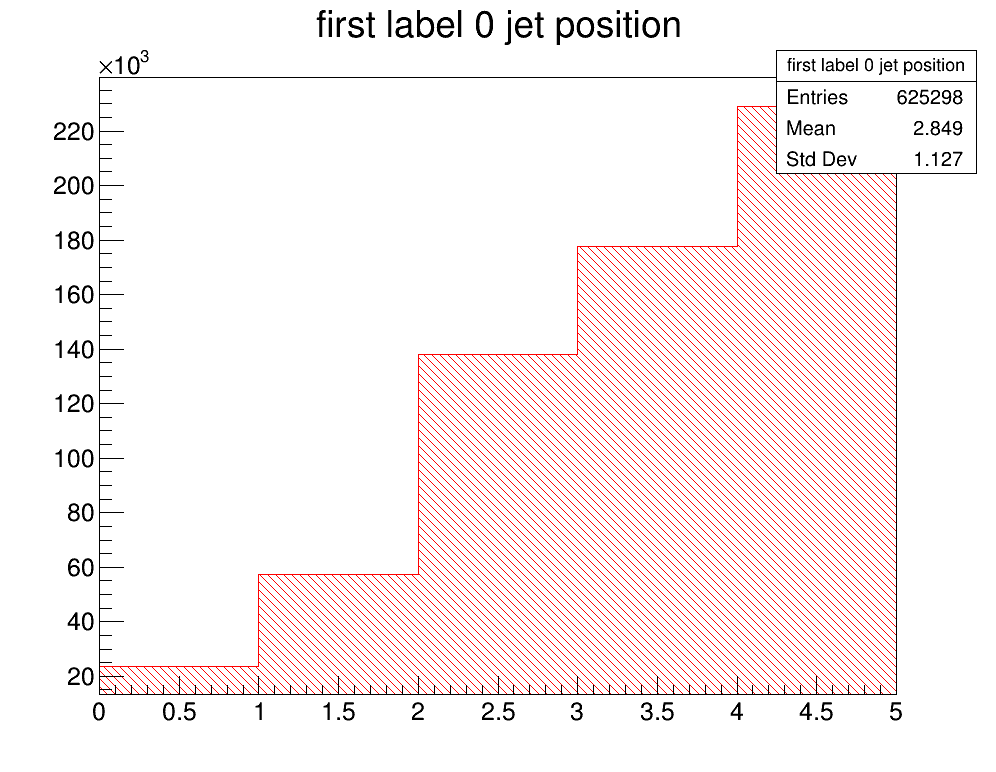

In [46]:
c1 = r.TCanvas("c1", "c1", 50, 50, 1000, 800)
histo.SetLineColor(r.kRed)
histo.SetFillColor(r.kRed)
histo.SetFillStyle(3005)
histo.Draw("hist")
c1.Draw()


# Codice che non serve ma conservo non si sa mai

In [ ]:
"""th=0.5
score = model_score(y_test, pred, th)
mp.rc('figure', figsize=(10,8), dpi=140)
pred = model.predict(x_test)
if th==0.5:
    pred = np.rint(pred)
else:
    i=0
    while i<len(pred):
        if pred[i]>th:
            pred[i]=1;
        else:
            pred[i]=0;
        i=i+1
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm,[0,1], title='Not normalized confusion matrix th = {}'. format(th))
plt.draw()
plt.savefig("/home/giacomo/tesi1/VBSAnalysis/images/load_model/matrices/NNCM_th{}.png".format(th))
plt.show()
plt.clf()
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized,[0,1], title='Normalized confusion matrix th = {}'.format(th))
plt.draw()
plt.savefig("/home/giacomo/tesi1/VBSAnalysis/images/load_model/matrices/NCM_th{}.png".format(th))
plt.show()
"""

In [ ]:
"""ths = []
score_zeros = []
score_unos = []""" 

In [ ]:
"""pred = model.predict(x_test)
th = 0.1
zeroindex = []
unoindex = []
i=0
for j in pred:
    if j<th:
        zeroindex.append(i)
    else:
        unoindex.append(i)
    i=i+1

newpredzero = []
newpreduno = []
zero_y_test = []
uno_y_test = []
for num in zeroindex:
    newpredzero.append(pred[num])
    zero_y_test.append(y_test[num])

for num in unoindex:
    newpreduno.append(pred[num])
    uno_y_test.append(y_test[num])
    
score_zero=metrics.accuracy_score(zero_y_test,[0]*len(newpredzero))
score_uno=metrics.accuracy_score(uno_y_test,[1]*len(newpreduno))
print(score_zero)
print(score_uno)"""

In [ ]:
"""ths.append(th)
score_zeros.append(score_zero)
score_unos.append(score_uno)"""

# APPLYING DNN TO STRATEGIES. FIRST 4 HIGHEST RATED JETS

In [22]:
from tqdm import tqdm_notebook

In [23]:
f = r.TFile("data/ewk_giacomo.root")

In [24]:
cuts = [
    ("pt_min_jets",30),
    ("min_njets",4),
    #("eq_njets",4),
    #("eta_max_jets", 2),
    ("eq_flag", 0),
    #("n_events", 100),
    ("atleastone_mjj_M", 250)
]

In [25]:
#questo canchero è stra lento va migliorato troppo...
#impiega circa 20/30 minuti
cwrt = 0
cwrg = 0
nevento = 0
ones = 0
#zeros = 0
good_event_count = 0
bad_event_count = 0
bad_event = []
b = []
final = []
previous_id = 0
g = 4
l = []
hs_v, h_v, h_v_bad = plotter.StackCreator1("Mjj Nearest W jets", "Nearest W good", "Nearest W bad")
hs_vbs, h_vbs, h_vbs_bad = plotter.StackCreator2("Max Mjj jets",  "Max Mjj good", "Max Mjj bad")

while g < 8:
        
    for evento in EventIterator(f,criteria = cuts, pairing = True) :
        pts = [j.Pt() for j in evento.jets]
        etas = [abs(j.Eta()) for j in evento.jets]
        ms = [j.M() for j in evento.jets]
        maxpt = max(pts)
        minpt = min(pts)
        maxeta = max(etas)
        maxm = max(ms)
        minm = min(ms)
        evento_jets_score = []
        for j in evento.jets:
            if evento.paired_parton(j) == None:
                    label = 0
            else:
                    label = 1
            datas = np.array([[j.Px(),j.Py(),j.Pz(),j.Pt(),j.E(), 
                                    maxpt, minpt, maxeta, maxm, minm]])
            pred = model.predict(datas)[0]
            evento_jets_score.append(([pred, j, label, nevento]))
        evento_jets_score= sorted(evento_jets_score, key= itemgetter(0), reverse=True)
        #print([j[2] for j in evento_jets_score[:5]])
        evento_jets_score = [j[1] for j in evento_jets_score[:g]]


        #applying strategies
        partons_pair1 = JetTagging.strategy_partons2(evento.partons)
        jets_pair1 = JetTagging.strategy_mw_mjj(evento_jets_score)
        associazione = JetTagging.check_association(evento, partons_pair1.vbs_pair, jets_pair1.vbsjets)
        #associazione vector boson
        associazione2 = JetTagging.check_association(evento, partons_pair1.w_pair,  jets_pair1.vjets)
        if associazione:
            #due getti vbs indici corrispondono a partoni
            h_vbs.Fill((jets_pair1.vbsjets[0]+jets_pair1.vbsjets[1]).M())
        else:
            #due getti vbs indici NON corrispondono a partoni
            h_vbs_bad.Fill((jets_pair1.vbsjets[0]+jets_pair1.vbsjets[1]).M())
        if associazione2:
            #due getti V indici corrispondono a partonieff
            h_v.Fill((jets_pair1.vjets[0]+jets_pair1.vjets[1]).M())
        else:
            #due getti V indici NON corrispondono a partoni
            h_v_bad.Fill((jets_pair1.vjets[0]+jets_pair1.vjets[1]).M())
        if associazione and associazione2:
            cwrt = cwrt +1
        else:
            cwrg = cwrg +1
    eff = cwrt/(cwrt+cwrg)
    l.append([eff, g])
    g = g+1
f = open("/home/giacomo/tesi1/VBSAnalysis/DNNTESTnjets.txt", "w")
i = 0
while i < len(l):
    f.write("{}\n".format(l[i]))
    i = i+1
f.close()

In [26]:
c1, pad1, pad2 = plotter.createCanvasPads()
pad1.cd()
hs_v.Draw("nostack hist")
legend = plotter.createLegend(h_v, h_v_bad,1)
legend.Draw("same")
pad2.cd()
hratio = plotter.createRatio(h_v, h_v +h_v_bad, "eff.")
hratio.Draw("hist")
hratio.SetFillColor(0)
hratioerror = hratio.DrawCopy("E2 same")
hratioerror.SetFillStyle(3013)
hratioerror.SetFillColor(13)
hratioerror.SetMarkerStyle(1)
hratio = plotter.RatioDrawOptions(hratio, "Nearest W Mjj jet (GeV)")
hratio.GetXaxis().SetLabelSize(0.07)
c1.Draw()

TypeError: none of the 2 overloaded methods succeeded. Full details:
  TLegendEntry* TLegend::AddEntry(const TObject* obj, const char* label = "", const char* option = "lpf") =>
    could not convert argument 1
  TLegendEntry* TLegend::AddEntry(const char* name, const char* label = "", const char* option = "lpf") =>
    could not convert argument 1 (bad argument type for built-in operation)

In [ ]:
c2, pad3, pad4 = plotter.createCanvasPads()
pad3.cd()
hs_vbs.Draw("nostack hist")
legend = plotter.createLegend(h_vbs, h_vbs_bad,1)
legend.Draw("same")
pad4.cd()
hratio = plotter.createRatio(h_vbs, h_vbs +h_vbs_bad, "eff.")
hratio.Draw("hist")
hratio.SetFillColor(0)
hratioerror = hratio.DrawCopy("E2 same")
hratioerror.SetFillStyle(3013)
hratioerror.SetFillColor(13)
hratioerror.SetMarkerStyle(1)
hratio = plotter.RatioDrawOptions(hratio, "Max Mjj Mjj jet (GeV)")
hratio.GetXaxis().SetLabelSize(0.07)
c2.Draw()

In [ ]:
print(eff)

# THRESHOLD TRY

In [7]:
from tqdm import tqdm_notebook

In [8]:
f = r.TFile("data/ewk_giacomo.root")

In [9]:
cuts = [
    ("pt_min_jets",30),
    ("min_njets",4),
    #("eq_njets",4),
    #("eta_max_jets", 2),
    ("eq_flag", 0),
    #("n_events", 100),
    ("atleastone_mjj_M", 250)
]

In [ ]:
#questo canchero è stra lento va migliorato troppo...
#impiega circa 20/30 minuti
cwrt = 0
cwrg = 0
nevento = 0
ones = 0
#zeros = 0
good_event_count = 0
bad_event_count = 0
bad_event = []
l = []
b = []
final = []
previous_id = 0
th = 0.3
hs_v, h_v, h_v_bad = plotter.StackCreator1("Mjj Nearest W jets", "Nearest W good", "Nearest W bad")
hs_vbs, h_vbs, h_vbs_bad = plotter.StackCreator2("Max Mjj jets",  "Max Mjj good", "Max Mjj bad")

while th < 1.:
    for evento in EventIterator(f,criteria = cuts, pairing = True) :
        pts = [j.Pt() for j in evento.jets]
        etas = [abs(j.Eta()) for j in evento.jets]
        ms = [j.M() for j in evento.jets]
        maxpt = max(pts)
        minpt = min(pts)
        maxeta = max(etas)
        maxm = max(ms)
        minm = min(ms)
        evento_jets_score = []
        score_jets = []
        for j in evento.jets:
            if evento.paired_parton(j) == None:
                    label = 0
            else:
                    label = 1
            datas = np.array([[j.Px(),j.Py(),j.Pz(),j.Pt(),j.E(), 
                                    maxpt, minpt, maxeta, maxm, minm]])
            pred = model.predict(datas)[0]
            evento_jets_score.append(([pred, j, label, nevento]))
        evento_jets_score= sorted(evento_jets_score, key= itemgetter(0), reverse=True)
        score_jets = [j[1] for j in evento_jets_score if j[0]>th]
        while len(score_jets) < 4:
            k = len(score_jets) + 1
            score_jets = [j[1] for j in evento_jets_score[:k]]

        #applying strategies
            
        partons_pair1 = JetTagging.strategy_partons2(evento.partons)
        jets_pair1 = JetTagging.strategy_mw_mjj(score_jets)
        associazione = JetTagging.check_association(evento, partons_pair1.vbs_pair, jets_pair1.vbsjets)
        #associazione vector boson
        associazione2 = JetTagging.check_association(evento, partons_pair1.w_pair,  jets_pair1.vjets)
        if associazione and associazione2:
            cwrt = cwrt +1
        else:
            cwrg = cwrg +1
            
    eff = cwrt/(cwrt+cwrg)
    l.append([eff, th])
    th = th + 0.1
        
f = open("/home/giacomo/tesi1/VBSAnalysis/DNNTESTth.txt", "w")
i = 0
while i < len(l):
    f.write("{}\n".format(l[i]))
    i = i+1
f.close()

In [ ]:
c1, pad1, pad2 = plotter.createCanvasPads()
pad1.cd()
hs_v.Draw("nostack hist")
legend = plotter.createLegend(h_v, h_v_bad,1)
legend.Draw("same")
pad2.cd()
hratio = plotter.createRatio(h_v, h_v +h_v_bad, "eff.")
hratio.Draw("hist")
hratio.SetFillColor(0)
hratioerror = hratio.DrawCopy("E2 same")
hratioerror.SetFillStyle(3013)
hratioerror.SetFillColor(13)
hratioerror.SetMarkerStyle(1)
hratio = plotter.RatioDrawOptions(hratio, "Nearest W Mjj jet (GeV)")
hratio.GetXaxis().SetLabelSize(0.07)
c1.Draw()

In [ ]:
c2, pad3, pad4 = plotter.createCanvasPads()
pad3.cd()
hs_vbs.Draw("nostack hist")
legend = plotter.createLegend(h_vbs, h_vbs_bad,1)
legend.Draw("same")
pad4.cd()
hratio = plotter.createRatio(h_vbs, h_vbs +h_vbs_bad, "eff.")
hratio.Draw("hist")
hratio.SetFillColor(0)
hratioerror = hratio.DrawCopy("E2 same")
hratioerror.SetFillStyle(3013)
hratioerror.SetFillColor(13)
hratioerror.SetMarkerStyle(1)
hratio = plotter.RatioDrawOptions(hratio, "Max Mjj Mjj jet (GeV)")
hratio.GetXaxis().SetLabelSize(0.07)
c2.Draw()

In [3]:
A = np.load("/home/giacomo/tesi1/VBSAnalysis/Dataset1.npy")
B = np.load("/home/giacomo/tesi1/VBSAnalysis/Dataset2.npy")

In [4]:
print(A.shape)
print(B.shape)

(5565538, 8)
(5565538, 10)
